# Binary classification: Predict if an asset will fail within certain time frame (e.g. cycles)

In [8]:
#Import libraries
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# for model creation
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

print('Print all libraries')

Print all libraries


In [9]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [10]:
# define path to save model
model_path = '/Output/binary_model.h5'

# Data Ingestion

In [11]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('C:/Users/vmadaram/Documents/CMAPSSData/train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('C:/Users/vmadaram/Documents/CMAPSSData/test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [12]:
# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('C:/Users/vmadaram/Documents/CMAPSSData/RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.info()
truth_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       100 non-null    int64
dtypes: int64(1)
memory usage: 928.0 bytes


,0
count,100.00000
mean,75.52000
std,41.76497
min,7.00000
25%,32.75000
50%,86.00000
75%,112.25000
max,145.00000


# Data Preprocessing

## TRAIN

In [13]:
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
#rul.info()
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  float64
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20  s16       20631 non-null  fl

In [14]:
# Generate label columns for training data
# We will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  float64
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20  s16       20631 non-null  fl

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862,0.150259,0.227813
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,68.880990,0.357334,0.575358
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000,0.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000,0.000000,0.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000,0.000000,0.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000,0.000000,0.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000,1.000000,2.000000


In [15]:
# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          20631 non-null  int64  
 1   cycle       20631 non-null  int64  
 2   setting1    20631 non-null  float64
 3   setting2    20631 non-null  float64
 4   setting3    20631 non-null  float64
 5   s1          20631 non-null  float64
 6   s2          20631 non-null  float64
 7   s3          20631 non-null  float64
 8   s4          20631 non-null  float64
 9   s5          20631 non-null  float64
 10  s6          20631 non-null  float64
 11  s7          20631 non-null  float64
 12  s8          20631 non-null  float64
 13  s9          20631 non-null  float64
 14  s10         20631 non-null  float64
 15  s11         20631 non-null  float64
 16  s12         20631 non-null  float64
 17  s13         20631 non-null  float64
 18  s14         20631 non-null  float64
 19  s15         20631 non-nul

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.0,...,20631.0,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,0.499490,0.501959,0.0,0.0,0.443052,0.424746,0.450435,0.0,...,0.0,0.434221,0.0,0.0,0.524241,0.546127,107.807862,0.150259,0.227813,0.298637
std,29.227633,68.880990,0.125708,0.244218,0.0,0.0,0.150618,0.133664,0.151935,0.0,...,0.0,0.129064,0.0,0.0,0.140114,0.149476,68.880990,0.357334,0.575358,0.190806
min,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,52.000000,0.413793,0.333333,0.0,0.0,0.335843,0.331807,0.339467,0.0,...,0.0,0.333333,0.0,0.0,0.434109,0.452361,51.000000,0.000000,0.000000,0.141274
50%,52.000000,104.000000,0.500000,0.500000,0.0,0.0,0.430723,0.415522,0.435348,0.0,...,0.0,0.416667,0.0,0.0,0.534884,0.557443,103.000000,0.000000,0.000000,0.285319
75%,77.000000,156.000000,0.586207,0.750000,0.0,0.0,0.539157,0.508829,0.545324,0.0,...,0.0,0.500000,0.0,0.0,0.627907,0.652582,155.000000,0.000000,0.000000,0.429363
max,100.000000,362.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,...,0.0,1.000000,0.0,0.0,1.000000,1.000000,361.000000,1.000000,2.000000,1.000000


## TEST

In [16]:
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.info()
test_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          13096 non-null  int64  
 1   cycle       13096 non-null  int64  
 2   setting1    13096 non-null  float64
 3   setting2    13096 non-null  float64
 4   setting3    13096 non-null  float64
 5   s1          13096 non-null  float64
 6   s2          13096 non-null  float64
 7   s3          13096 non-null  float64
 8   s4          13096 non-null  float64
 9   s5          13096 non-null  float64
 10  s6          13096 non-null  float64
 11  s7          13096 non-null  float64
 12  s8          13096 non-null  float64
 13  s9          13096 non-null  float64
 14  s10         13096 non-null  float64
 15  s11         13096 non-null  float64
 16  s12         13096 non-null  float64
 17  s13         13096 non-null  float64
 18  s14         13096 non-null  float64
 19  s15         13096 non-nul

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,13096.0,13096.000000,13096.000000,13096.000000,13096.0,...,13096.000000,13096.000000,13096.000000,13096.0,13096.000000,13096.0,13096.0,13096.000000,13096.000000,13096.000000
mean,51.543907,76.836515,0.499358,0.503532,0.0,0.0,0.381051,0.371903,0.379564,0.0,...,0.280919,0.201299,0.388395,0.0,0.380969,0.0,0.0,0.583335,0.609697,0.210073
std,28.289423,53.057749,0.126591,0.245025,0.0,0.0,0.120753,0.109075,0.112902,0.0,...,0.083727,0.052578,0.111617,0.0,0.102798,0.0,0.0,0.109830,0.116156,0.146974
min,1.000000,1.000000,0.028736,0.000000,0.0,0.0,-0.024096,-0.043601,0.036124,0.0,...,0.014706,0.044174,0.030396,0.0,0.083333,0.0,0.0,0.131783,0.056890,0.000000
25%,28.000000,33.000000,0.413793,0.333333,0.0,0.0,0.297440,0.295618,0.298785,0.0,...,0.220588,0.167045,0.310504,0.0,0.333333,0.0,0.0,0.511628,0.534935,0.088643
50%,52.000000,69.000000,0.500000,0.500000,0.0,0.0,0.376506,0.369523,0.374578,0.0,...,0.279412,0.198421,0.384763,0.0,0.416667,0.0,0.0,0.589147,0.614471,0.188366
75%,76.000000,113.000000,0.586207,0.750000,0.0,0.0,0.460843,0.443046,0.452397,0.0,...,0.338235,0.229229,0.459407,0.0,0.416667,0.0,0.0,0.658915,0.689589,0.310249
max,100.000000,303.000000,0.948276,1.083333,0.0,0.0,0.930723,0.795945,0.862762,0.0,...,0.647059,0.622046,0.833013,0.0,0.750000,0.0,0.0,0.984496,1.032450,0.836565


In [17]:
# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [18]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

In [19]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [20]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [21]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


# LSTM - Model Creation

In [22]:
# pick a large window size of 50 cycles
sequence_length = 50

In [23]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [24]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [25]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [26]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [27]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

In [28]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

## Build Deep network

In [29]:
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# fit the network
history = model.fit(seq_array, label_array, 
                    epochs=100, 
                    batch_size=200, 
                    validation_split=0.05, 
                    verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Epoch 1/100
75/75 - 10s - loss: 0.2559 - accuracy: 0.8901 - val_loss: 0.0469 - val_accuracy: 0.9872 - 10s/epoch - 135ms/step
Epoch 2/100
75/75 - 6s - loss: 0.1009 - accuracy: 0.9595 - val_loss: 0.0693 - val_accuracy: 0.9693 - 6s/epoch - 75ms/step
Epoch 3/100
75/75 - 6s - loss: 0.0877 - accuracy: 0.9644 - val_loss: 0.0473 - val_accuracy: 0.9834 - 6s/epoch - 78ms/step
Epoch 4/100
75/75 - 6s - loss: 0.0746 - accuracy: 0.9692 - val_loss: 0.0354 - val_accuracy: 0.9834 - 6s/epoch - 84ms/step
Epoch 5/100
75/75 - 6s - loss: 0.0672 - accuracy: 0.9733 - val_loss: 0.0418 - val_accuracy: 0.9834 - 6s/epoch - 78ms/step
Epoch 6/100
75/75 - 6s - loss: 0.0685 - accuracy: 0.9718 - val_loss: 0.0393 - val_accuracy: 0.9847 - 6s/epoch - 76ms/step
Epoch 7/100
75/75 - 6s - loss: 0.0617 - accuracy: 0.9733 - val_loss: 0.0418 - val_accuracy: 0.9821 - 6s/epoch - 80ms/step
Epoch 8/100
75/75 - 6s - loss: 0.0565 - accuracy: 0.9759 - val_loss: 0.0474 - val_accuracy: 0.9795 - 6s/epoch - 78ms/step
Epoch 9/100
75/75 - 6

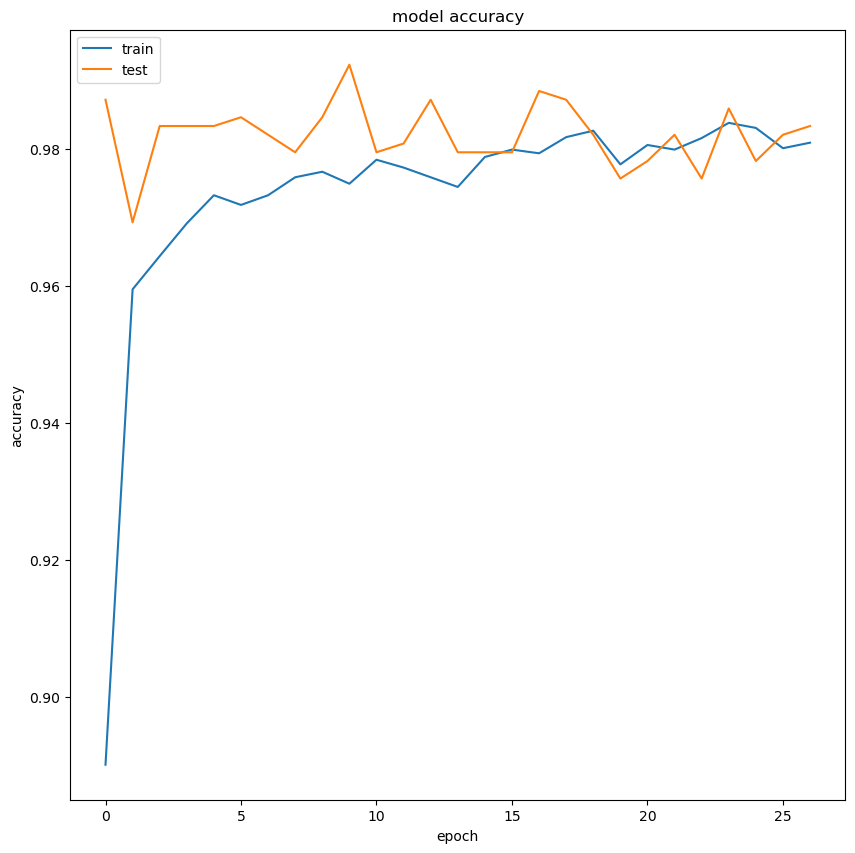

In [31]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("Output/model_accuracy.png")

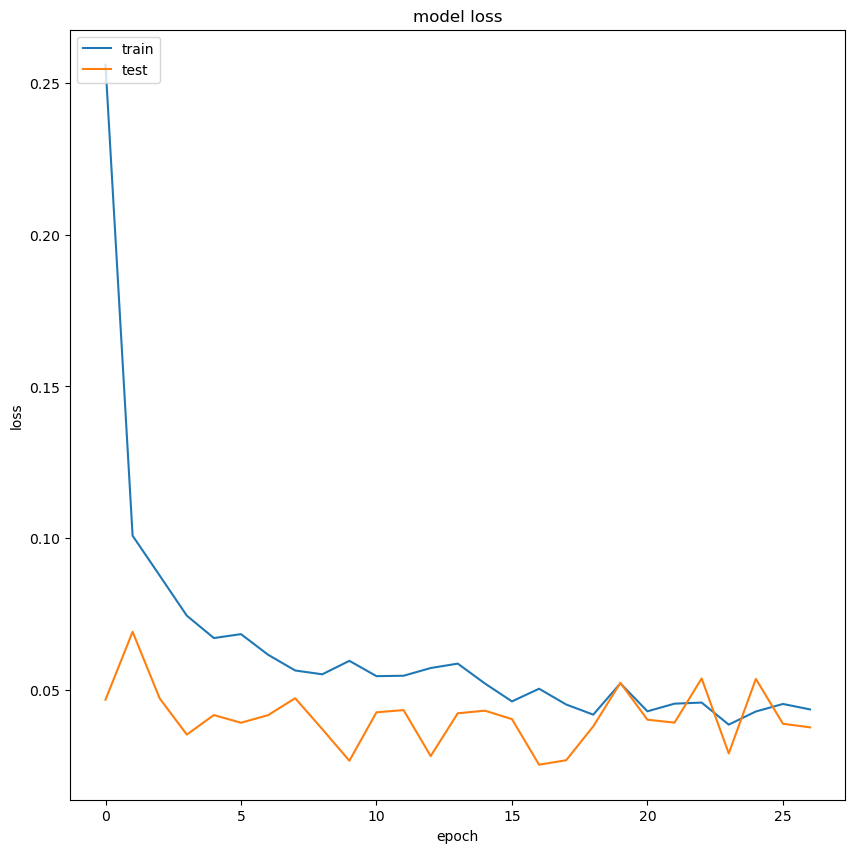

In [32]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("Output/model_loss.png")

In [33]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))


79/79 [==============================] - 3s 33ms/step - loss: 0.0351 - accuracy: 0.9860
Accurracy: 0.9859893918037415


In [34]:
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array) > 0.5).astype("int32")

y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('Output/binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

489/489 [==============================] - 7s 13ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12383   148]
 [   71  3029]]


In [35]:
seq_array

array([[[0.4597701 , 0.16666667, 0.        , ..., 0.        ,
         0.7131783 , 0.7246617 ],
        [0.6091954 , 0.25      , 0.        , ..., 0.        ,
         0.6666667 , 0.73101354],
        [0.25287357, 0.75      , 0.        , ..., 0.        ,
         0.627907  , 0.6213753 ],
        ...,
        [0.6091954 , 0.5833333 , 0.        , ..., 0.        ,
         0.62015504, 0.65009665],
        [0.41954023, 0.9166667 , 0.        , ..., 0.        ,
         0.7131783 , 0.7671914 ],
        [0.31609195, 0.41666666, 0.        , ..., 0.        ,
         0.5503876 , 0.7130627 ]],

       [[0.6091954 , 0.25      , 0.        , ..., 0.        ,
         0.6666667 , 0.73101354],
        [0.25287357, 0.75      , 0.        , ..., 0.        ,
         0.627907  , 0.6213753 ],
        [0.54022986, 0.5       , 0.        , ..., 0.        ,
         0.5736434 , 0.66238606],
        ...,
        [0.41954023, 0.9166667 , 0.        , ..., 0.        ,
         0.7131783 , 0.7671914 ],
        [0.3

In [36]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9534151715454832 
 recall =  0.9770967741935483


##################################
# EVALUATE ON TEST DATA
##################################

In [37]:
# We pick the last sequence for each id in the test data

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last)
print(seq_array_test_last.shape)

seq_array_test_last
[[[0.3505747  0.8333333  0.         ... 0.         0.4728682  0.45457056]
  [0.39655173 0.5833333  0.         ... 0.         0.6511628  0.5608948 ]
  [0.5114943  0.25       0.         ... 0.         0.6356589  0.4975145 ]
  ...
  [0.43678162 0.75       0.         ... 0.         0.41860464 0.4710025 ]
  [0.5804598  0.6666667  0.         ... 0.         0.3255814  0.45954156]
  [0.40804598 0.8333333  0.         ... 0.         0.6124031  0.52444077]]

 [[0.55172414 0.25       0.         ... 0.         0.5503876  0.6974593 ]
  [0.39655173 0.5833333  0.         ... 0.         0.37209302 0.59748685]
  [0.5344828  0.16666667 0.         ... 0.         0.51937985 0.602596  ]
  ...
  [0.43103448 0.33333334 0.         ... 0.         0.56589144 0.49461475]
  [0.33908045 0.25       0.         ... 0.         0.4108527  0.5223695 ]
  [0.5689655  0.8333333  0.         ... 0.         0.34108528 0.5024855 ]]

 [[0.7356322  0.25       0.         ... 0.         0.53488374 0.6023198 ]
  

In [38]:
# Similarly, we pick the labels

#Take only the labels of sequences that are at least 50 long
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
print("y_mask")
print(y_mask)
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)

y_mask
[False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
(93, 1)
label_array_test_last
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 

3/3 - 1s - loss: 0.0562 - accuracy: 0.9677 - 695ms/epoch - 232ms/step
Accurracy: 0.9677419066429138
3/3 [==============================] - 0s 13ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 1 24]]
Precision:  0.9230769230769231 
 Recall:  0.96 
 F1-score: 0.9411764705882353


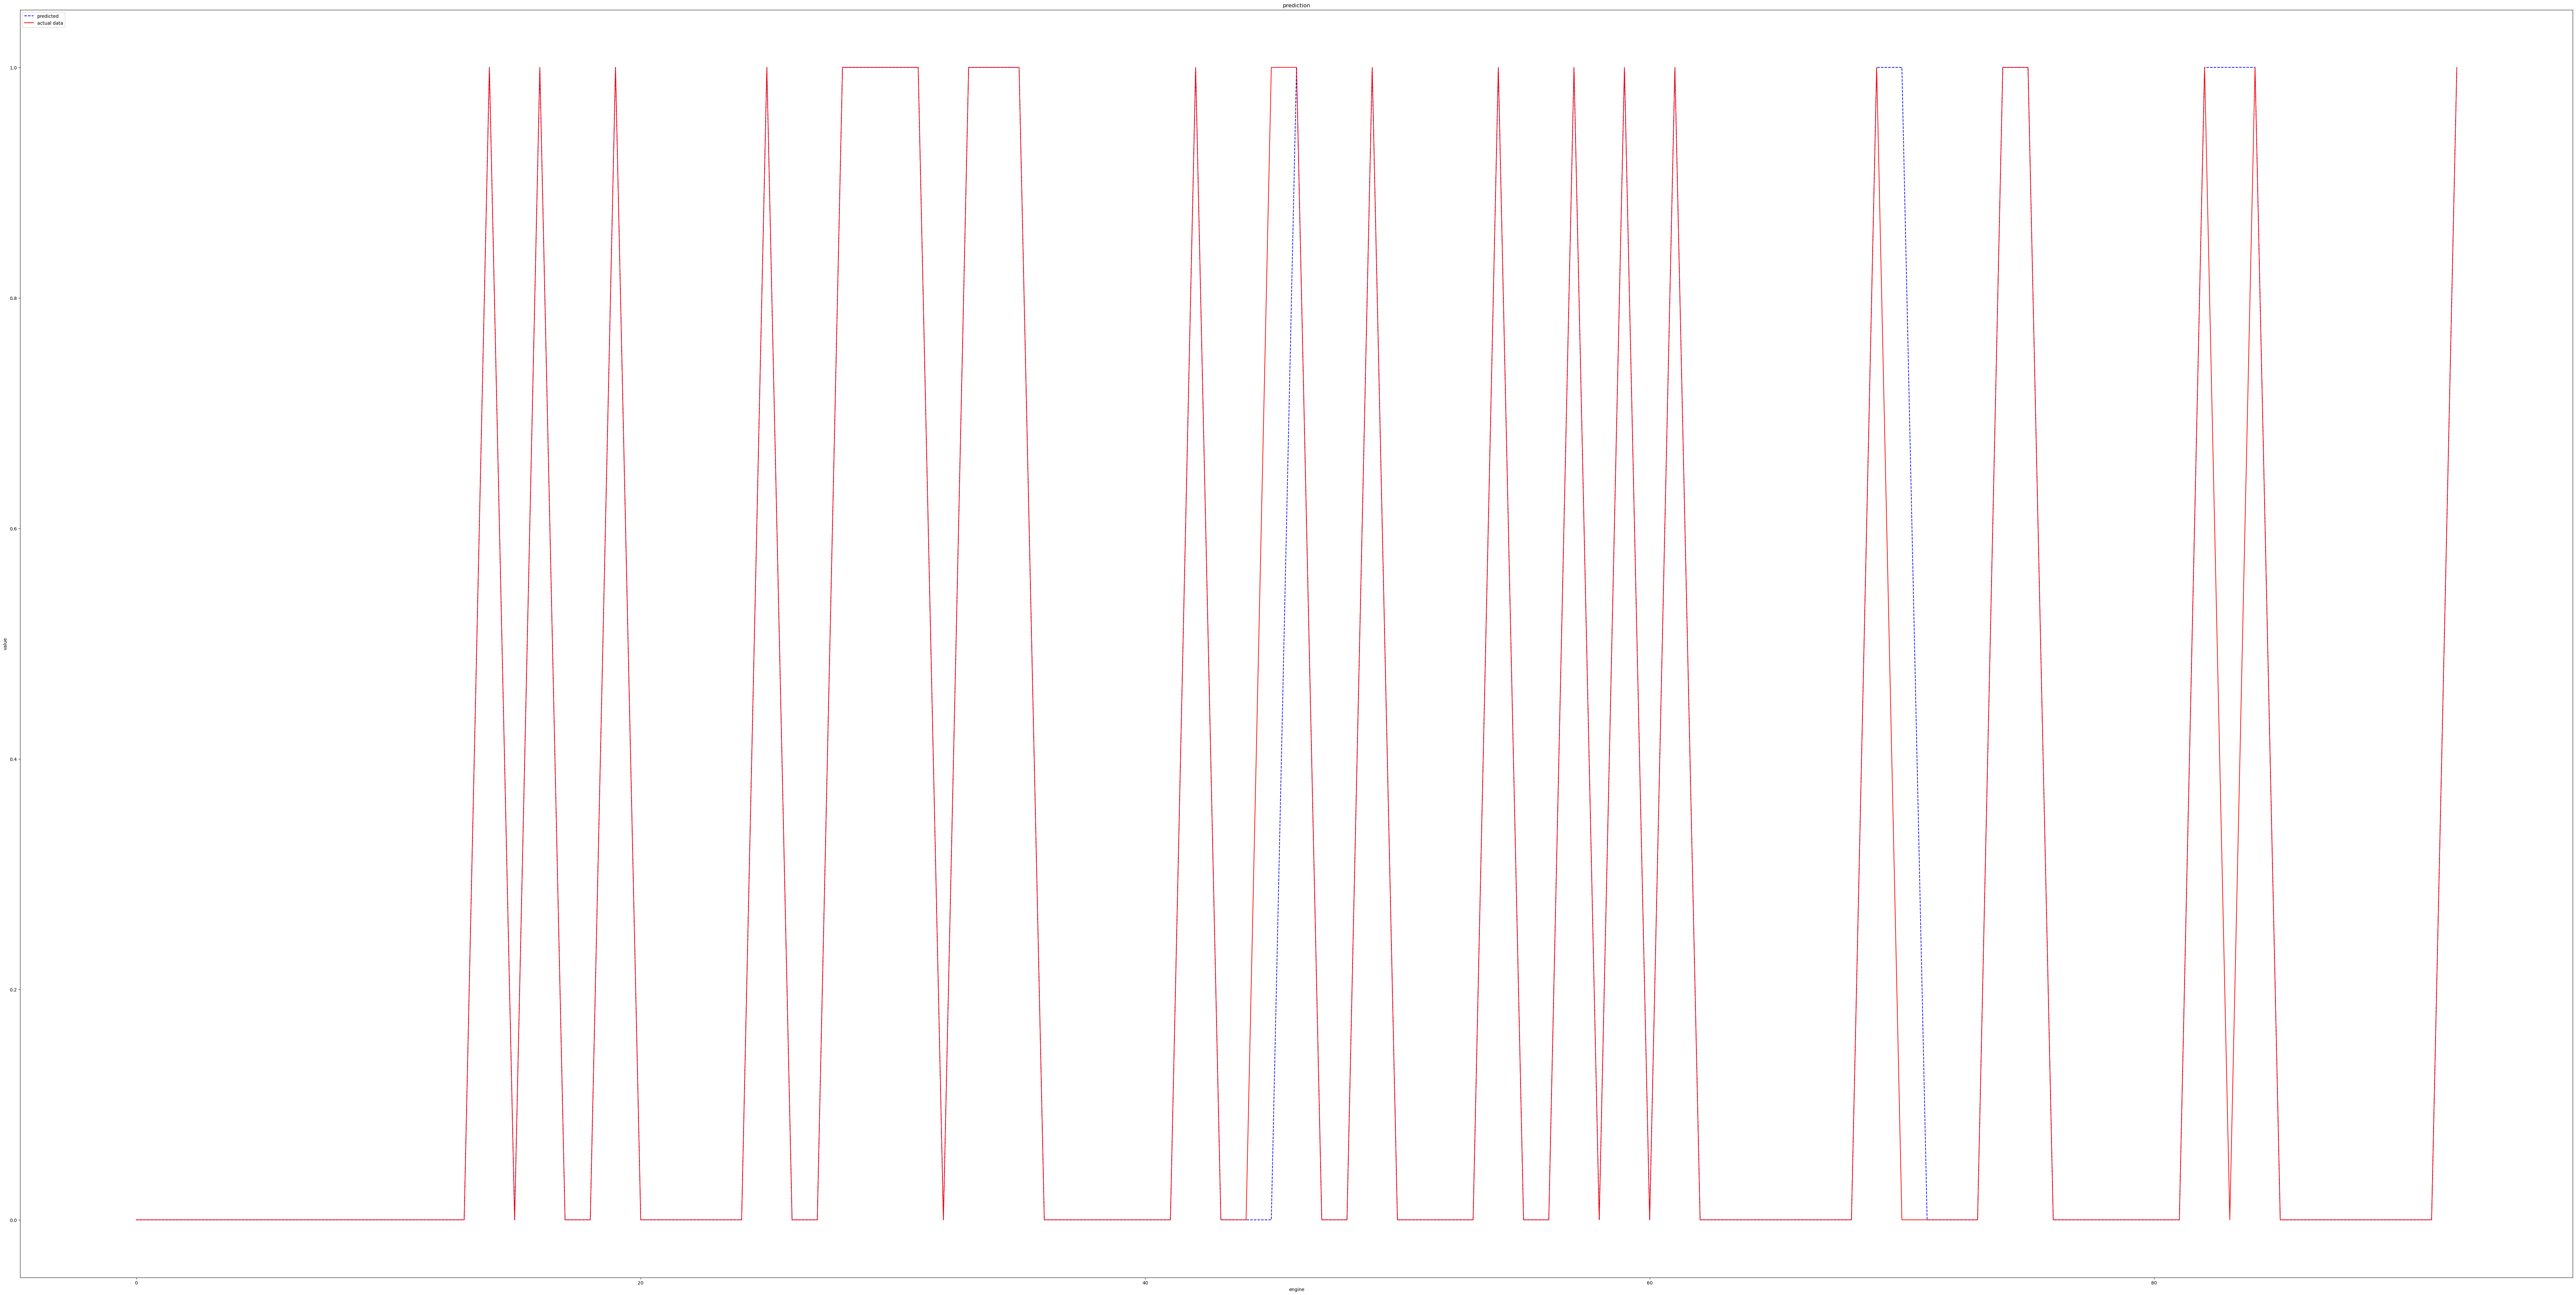

In [39]:
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)
    
    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('Accurracy: {}'.format(scores_test[1]))
    
    # make predictions and compute confusion matrix
    y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")

    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('Output/binary_submit_test.csv', index = None)

    print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
    cm = confusion_matrix(y_true_test, y_pred_test)
    print(cm)
    
    # compute precision and recall
    precision_test = precision_score(y_true_test, y_pred_test)
    recall_test = recall_score(y_true_test, y_pred_test)
    f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
    print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )
    # Plot in blue color the predicted data and in green color the actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(100, 50))
    plt.plot(y_pred_test, color="blue", linestyle='dashed', linewidth=1.5)
    plt.plot(y_true_test, color="red")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('engine')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("Output/model_verify.png")

##################################
# Next Steps /Improvements?
## 1. Optimization of Hyper parameters 
## 2. Investing more time in Feature egninnering
## 3. Try to perform a mutli-classification where we predict if the engines would fail in different time windows 

##################################




# References
1] Deep Learning for Predictive Maintenance https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb

[2] Predictive Maintenance: Step 2A of 3, train and evaluate regression models https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2

[3] A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA

[4] Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/

